<a href="https://colab.research.google.com/github/climate-in-the-cloud/workshop/blob/master/optimal-interpolation/optimal_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://raw.githubusercontent.com/climate-in-the-cloud/workshop/master/optimal-interpolation/mercator_temperature.png)

# Lab C: Optimal Interpolation

In this lab, we will look at some ocean model data and use it to calculate a covariance function fitted to some "measurements". Using this covariance function, we can use a process called optimal interpolation to estimate the state of the ocean using our available measurements. 

By the end of this lab, you will be able to 

- import data into the Colab environment
- create synthetic "measurements" of ocean temperature data by subsampling the dataset and adding random errors
- compute the lagged binned covariance function from the data and fit it to standard functional forms 
- calculate the data covariance matrix using the fitted covariance function
- Reconstruct an estimate of the temperature at every point using optimal interpolation. 


## Background

The covariance is an important quantity in optimal interpolation and other inverse problems. It gives us an estimate of the uncertainty in our model or data, which tells us how much we should trust this when we use it in our state estimate. 

The covariance is often calculated empirically, that is, from data. We want to use a large enough data set so that our estimate will be *unbiased*, that is, the mean of the data is close to the mean of the true state of the system. If we use too small a data set, our estimate can become biased and our estimate will be a poor representation of the true state. 

In this lab, we will make a large number of synthetic measurements of ocean temperature and use these to construct an empirical covariance function. We will then use this function to evaluate the covariance matrix of the data, and use this to create an optimally interpolated estimate of the data everywhere. 

The data set we will use is ocean temperature data in the North Atlantic from [Mercator Ocean](http://bulletin.mercator-ocean.fr), the French operational ocean forecast system. 

# An introduction to Python

In this course, we will use [Python](https://www.python.org/) to run fluid dynamics simulations, analyze output, and plot figures and movies. Python is free, flexible, easy to use, and has tons of online resources for beginners. If you have a question about Python, my default answer will be "have you Googled it?"

You do not need to be fluent in Python or any other programming language for this course. We will run Python from within these notebooks, and you will get lots of guidance. You are also encouraged to complete this [free online tutorial](https://www.codecademy.com/learn/learn-python) to familiarise yourself with Python syntax.

If you are comfortable with Python and the Colab notebook environment, you can skip this section and move straight to "Experimental setup". 


## Google Colaboratory

[Google Colaboratory](http://colab.research.google.com/) (or "Colab", for short) is a python notebook that you can run in a browser window. Colab notebooks are hosted on the cloud, which means that you do not need to have python installed on your local machine --- you can run it straight from a web browser. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI)  to learn more, or check out this [Overview of Colab Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). 

You can sign up for a (free) [Google Account](https://myaccount.google.com/intro) to run the notebooks. This will allow you to save your notes, output, and so on and also connect to Google Drive. If you would prefer not to sign up, you can still run the notebook by selecting File > Open in Playground Mode in the menu bar. 



## Python notebooks

We will run python scripts in interective, web-based, computational environments called notebooks. Within a notebook you can display text, mathematical notation, images, etc, using [Markdown](https://www.markdownguide.org/). For example:

### World's most awesome equations: 

- Newton's second law: $F = m \dot{v}$. 
- Euler's equation: $e^{\mathrm{i} \pi} + 1 = 0$. 
- Wave equation ("_gnarly dude!_"): 
$$
\frac{\partial^2 f}{\partial t^2} = c^2 \frac{\partial^2 f}{\partial x^2}.
$$


If you double-click any cell, you can see the Markdown code used to create it. 

Notebooks also allow you to use "cells" of python code that be executed in real time. 

To see this in action, move down to the next cell and enter the following python code: 

```
string = "Hello world!"
print(string)
```

When you are finished, press **SHIFT + ENTER** to run the cell (or press the **Play button** on the left-side of the code cell). 

In [ ]:
# This is a comment reminding you to enter your python code below. Don't forget to press shift + enter to run!

Congratulations! You are now a pythonista. Variables carry over from cell to cell, so you can build complex scripts by sequentially running cells one after another. 

Now create a new cell by clicking on the "+" button in the menu above. Make sure that the cell type is "Code" in the drop down menu. Navigate to the new cell and enter the following python code: 

```
longer_string = string + " spam! Spam! SPAM!"
print(longer_string)
```

Don't forget to **SHIFT + ENTER** to run the cell. 

## Libraries

Python makes extensive use of freely available, open source *libraries*, which contain tonnes of useful functions etc that you can make use of. The following python code calls two standard libraries: `numpy` (pronounced "numb pie"), which contains useful functions for carrying out numerics, and `matplotlib`, which allows us to plot data.

Since we will be using these libraries repeatedly, we will abbreviate their names to `np` and `plt`, respectively.

Finally, the last line instructs `matplotlib` to plot figures in the notebook, just below the cell that calls it. That way, you will be able to view and save figures within the notebook. 

**Move to the next cell by pressing DOWN, then press SHIFT + ENTER to run (or click "Run" in the menu above)**

In [ ]:
# Numerics
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# plot figures in Jupyter notebook
%matplotlib inline

## Variables, arrays, and indexing

The first thing we need to do is define a numerical grid. We will do this using the `numpy` functions `linspace` and `meshgrid`. Thus, when we call them, we will use the alias we defined for this library, `np`, followed by a period `.` followed by the particular function we want from the library, e.g. `np.linspace`.

First, we create a vector `xv` of `2n+1` equally spaced gridpoints between $x = -1$ and $x = 1$. Again, press **shift + enter** to run the following cell. 

In [ ]:
# Grid
n = 50
xv = np.linspace(-1,1,2*n+1)

print(xv.shape)
print(xv[0:10])
print(xv[-10:])

The command `print(xv.shape)` prints the dimensions of the array `xv`. In this case, it is a 1D array with `2n+1` elements, so the dimensions are $(2n+1,)$. Notice that the second dimension is simply blank, rather than `1`. 

The commands `print(xv[0:10])` and `print(xv[-10:])` print the first and last ten elements of the array. Indexing in python is indicated using square brackets `[...]` and is referenced to the first element (for positive indices) or the last element (for negative indices). Thus, `xv[0:10]` can be read as: "first + 0 elements to first + 10 elements", and `xv[-10:]` can be read as: "last - 10 elements to last element". 

Next we will define 2D arrays `xx` and `yy` using the function `meshgrid`. 

In [ ]:
xx,yy = np.meshgrid(xv,xv,indexing='ij')

print(xx.shape)
print(yy.shape)

print(xx[0:10,0:10])
print(yy[0:10,0:10])

The array `xx` is an $2n+1 \times 2n+1$ matrix in which each row is the corresponding value of `xv`. Likewise, the array `yy` is an $2n+1 \times 2n+1$ matrix with each column having the corresponding value of `xv`. 

Let's try plotting a simple function of x and y using the arrays `xx` and `yy`. The function we will use is 

$$
f = \sin  (\pi x) 
$$

Both the sine function and the constant pi are part of the `numpy` library, so we call the using `np.sin` and `np.pi`, respectively. 

In [ ]:
# define function
f = np.sin(np.pi*xx)

We will make a 2D colorplot of this function using `plt.pcolormesh`, as well as a 1D plot of a slice of the function using `plt.plot`. We will also use some other functions from `matplotlib` to control the appearance of the figure, such as `subplot`, `title`, `xlabel`, etc. 

In [ ]:
# plot 2D colorplot
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, f)
plt.title('f(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

# plot 1D slice along y = 0
plt.subplot(1,2,2)
plt.plot(xv,f[:,n])
plt.title('f(x,0)')
plt.xlabel('x')
plt.axis('square')
plt.ylim(-1.1,1.1)

--------------

### Exercises

- Modify the function `f` above so that it is $f = \cos (\pi y)$ and plot a 2D colormap of the function. To do this, you will need to run (**shift + enter**) both cells: the cell that defines `f` and the cell that plots `f`. 

- How should you change the 1D plot so that it shows a slice along $x = 0$ instead of $y = 0$? 

- Try plotting a more complication function like $f = \sin (\pi x) \cos (\pi y$). 

------------------

# Experimental setup


### Libraries

Let's begin by importing some useful libraries. You will see two new libraries here, `h5py`, which is used to import data that has been save in the HDF5 format, and `random` which we will use to create random errors and samples. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
%matplotlib inline

### Upload the data

The data has been saved in a file called `mercator_temp.h5` and can be found on the [GitHub repository](https://github.com/climate-in-the-cloud/workshop/tree/master/optimal-interpolation) for this lab: 

```
https://github.com/climate-in-the-cloud/workshop/tree/master/optimal-interpolation
```

You should download this file to your local machine (it is about 3 Mb). 

Remember, the local directory of the Colab session is not the same as your own local directory, so you will need to upload the file in order to be able to manipulate it in Colab. There are a number of ways to do this: 

- The most straightforward method is to use the upload functionality of Colab. Navigate to the menu bar on the left of the Colab window and click on the folder icon. You may need to wait a moment to let Colab initialize the runtime. You will be able to see a file tree (these are the files available to Colab). You will also see an "Upload" button which you can use to upload the file to Colab. 

- If you have a Google account, you can mount your Google drive within the Colab environment: 
```
from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive'
```
You will need to add the file to your Google Drive. From there it will now be visible to Colab. 



### Import the data into the Colab environment

Once the data file `mercator_temp.h5` has been uploaded to Colab, it needs to be imported into the Colab notebook environment. We will do this using some tools from the `h5py` library. 

In [40]:
# load temperature and grid data

file = h5py.File('mercator_temp.h5','r')
temp = file['/data/temp'][:]
lon  = file['/data/x'][:]
lat  = file['/data/y'][:]
z    = file['/data/z'][:]

file.close()

### Plot the data

Let's start off by plotting the data to see what it looks like. The temperature field `temp` is a 3D data cube (latitude x longitude x depth). To plot a 2D snapshot of the temperature, we can specify a particular depth index. Once we have done that, we can plot the data using a `meshgrid` of the latitude and longitude coordinates (`x` and `y`). 

This type of plot is called (appropriately enough) a *Mercator projection*. In this projection, a degree of latitude or longitude has the same length everywhere on the globe. This leads to some distortions, especially at higher latitudes. For example, on a typical world map using a Mercator projection, Greenland and Africa look approximately the same size, when in fact [Africa is 14 times larger than Greenland](https://www.youtube.com/watch?v=vVX-PrBRtTY). In this lab, we be looking at a limited degree box of the North Atlantic, so this is not such a big problem, although we will need to convert to a local cartesian coordinate system to calculate distances. 


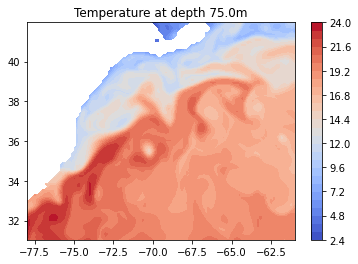

In [41]:
k = 10        # depth level for temperature data

lon_,lat_ = np.meshgrid(lon,lat,indexing='ij') # create a meshgrid of lat/lon

# plot the data
fig, ax = plt.subplots()
cax = ax.contourf(lon_, lat_, temp[:,:,k],32,cmap=plt.cm.coolwarm)
ax.set(title='Temperature at depth ' + str(z[0,k]) + 'm')
cbar = fig.colorbar(cax)

-------------------
**Exercise**

- Can you plot an east-west (zonal) slice of the data on a longitude-depth axis? 

- How about a north-south (meridional) slice on a latitude-depth axis? 

------------------------

### Create synthetic observations

We will now subsample the data at random grid points to simulate a series of observations over the domain. For example, these observations could come drifting profiling floats (such as the [Argo network](http://www.argo.ucsd.edu/About_Argo.html)). We will also add some random errors to simulate measurement noise.  

In [42]:
frac = 0.1    # fraction of data to retain 
e = 0.4       # random error to add to obs (deg C)
k = 10        # depth level for temperature data

# flatten the coordinate and temperature arrays in 1D arrays
lonv = lon_.flatten()
latv = lat_.flatten()
data = temp[:,:,k].flatten()

# remove land data (indicated by NaNs in our dataset)
lonv = lonv[np.logical_not(np.isnan(data))]
latv = latv[np.logical_not(np.isnan(data))]
data = data[np.logical_not(np.isnan(data))]

# randomly permute the grid points so the first Nm are observed 
r = np.random.permutation(range(0,data.size))
Nm = round(frac*data.size) # number of observed data points
Ni = data.size - Nm        # number of unobserved (interpolated) data points
rm = r[0:Nm]
ri = r[Nm:]

# subsample the data and add random measurement errors
lonm = lonv[rm]
latm = latv[rm]
vm = data[rm] + e*np.random.normal(0,1,rm.size)

# unsampled data (missing gridpoints)
loni = lonv[ri]
lati = latv[ri]
vi = data[ri]

### Plot the measurements

Now let's compare the try ocean state with our observations. 

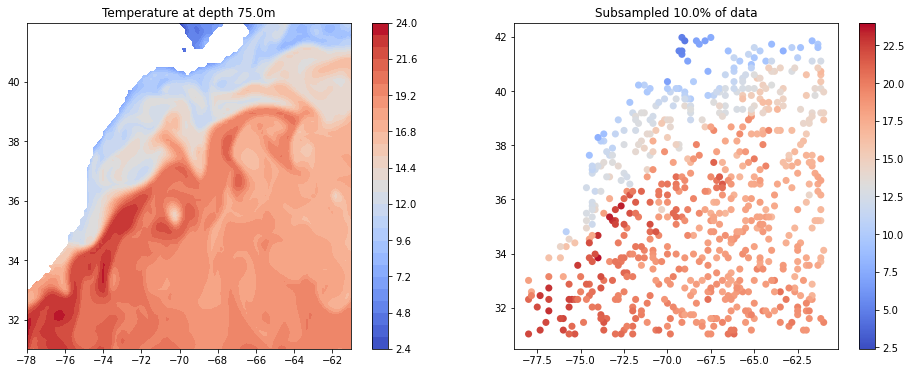

In [43]:
lon_,lat_ = np.meshgrid(lon,lat,indexing='ij')

fig = plt.figure(figsize=(16,6))

ax  = fig.add_subplot(1,2,1)
cax = ax.contourf(lon_, lat_, temp[:,:,k],32,cmap=plt.cm.coolwarm)
ax.set(title='Temperature at depth ' + str(z[0,k]) + 'm')
cbar = fig.colorbar(cax)

ax = fig.add_subplot(1,2,2)
cax = ax.scatter(lonm, latm, c=vm, s=50, edgecolors="none",cmap=plt.cm.coolwarm, vmax=24,vmin=2.4)
ax.set(title='Subsampled ' + str(round(100*Nm/data.size,2)) + '% of data')
cbar = fig.colorbar(cax)

## Calculate the covariance between data points

We will now make an estimate of the data covariance function by computing binned-lagged covariance for all data pairs. We first need to know how the distance between every pair of data points. We will do this by converting latitude and longitude to kilometers using a cartesian plane approximation to the sphere:

$$
x \approx R_e ( \theta - \theta_0 ) \cos \left( \lambda \right) \\
y \approx R_e \left( \lambda - \lambda_0 \right)  
$$

where $R_e$ is Earth's radius, ($\theta$, $\lambda$) are the longitude and latitude (in radians), and ($\theta_0$, $\lambda_0$) are the latitude and longitude where the cartesian plane touches the sphere (i.e. the middle of the plane). 

Once we have approximate cartesian coordinates for the data points, we will create a `meshgrid` $X$ and $Y$ and calculate the distance between points using

$$ 
dX = X - X^T, \quad dY = Y - Y^Y.
$$

Here, $X$ and $Y$ are $Nm \times Nm$ matrices ($Nm$ is the number of data points) and $X^T$ is the transpose of $X$. 

The cartesian distance between data points $m$ and $n$ is then 

$$
R_{mn} = \left( dX_{mn}^2 + dY_{mn}^2 \right) 
$$

The resulting matrix $\mathsf{R}_{dd}$ is symmetric (because the distance between $m$ and $n$ is the same as the distance between point $n$ and $m$) with a row of zeros along the diagonal (because the distance between $m$ and itself is zero). 


In [45]:
# Get distances separating every pair of stations using approximate
# spherical geometry
lon0 = (np.max(lon)+np.min(lon))/2
lat0 = (np.max(lat)+np.min(lat))/2
rearth = 6370.8; # kilometres

# xm, ym will be the coordinates of the data (converted from lon/lat)
xm = []
ym = []

for m in range(0,Nm):
  xm.append(rearth*(np.pi/180*(lonm[m]-lon0))*np.cos(np.pi/180*latm[m]))
  ym.append(rearth*(latm[m]-lat0)*np.pi/180)

xm_,ym_ = np.meshgrid(xm,ym,indexing='ij')

dxm = xm_ - np.transpose(xm_)
dym = ym_ - np.transpose(ym_)

# Note that in python * indicates elementwise multiplication, not matrix multiplication. 
Rdd = np.sqrt(dxm*dxm + dym*dym)

### Binned lagged covariance function

The covariance is calculated from the data $v_m$ as 

$$
C_{mn} = \left( v_m - \overline{v} \right) \left( v_n - \overline{v} \right)
$$

where $\overline{v}$ is the average value of $v_m$. 

Assuming isotropy (direction independence) and homogeniety (translation independence), the covariance will be a function of distance only, ie $C = C(r)$. We will now compute the covariance as a function of distance by binning by distance. 

Note that the assumptions of homogeneity and isotropy generally do not hold in the ocean, but they are acceptable across a limited range of scales. 

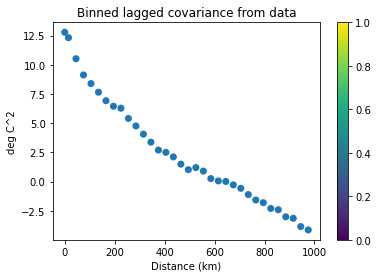

In [46]:
## Compute the binnned lagged covariance function

# remove mean before calculating covariance
d = vm-np.mean(vm)

# covariance
C = np.tensordot(d,d,axes=0)

# set the distance bins
dr = 30
nbins = int(np.floor(1000/dr)) + 1
r = np.zeros(nbins)
r[1:] = np.linspace(15,975,nbins-1)

# variance of samples that fall into each bin
cf = np.zeros(nbins)
cf[0] = np.mean(np.diag(C))

for b in range(1,nbins):
  ind = np.where( (Rdd > r[b]-0.5*dr) & (Rdd <= r[b]+0.5*dr))
  if ind[0].size > 0:
    cf[b] = np.mean(C[ind[0],ind[1]])

fig, ax = plt.subplots()
cax = ax.scatter(r, cf, s=50, edgecolors="none")
ax.set(title='Binned lagged covariance from data')
ax.set(xlabel='Distance (km)')
ax.set(ylabel='deg C^2')
cbar = fig.colorbar(cax)

## Fit the covariance

We would like to be able to capture the essential features of the empirical covariance $C(r)$ in just a few parameters. We next fit the empirical covariance to a simple functional form, 

$$
C_G (r) = a \exp \left( - \frac{r^2}{b^2} \right) 
$$

This is a Gaussian with amplitude $a$ and width $b$. If we can estimate the values of $a$ and $b$ from the data, we will be able to use this functional form to estimate the covariance of any two points in space. 

There are many options for fitting functions like this. We will use a very simple approach. The value of $C_G(0)$ is given by 

$$
C_G(0) = a.
$$

Thus, we can determine $a$ by demanding that the Gaussian fit matches the empirical covariance as $r \rightarrow 0$. (Note that we don't want to fit it exactly at zero because the covariance has some measurement noise at $r = 0$). 

Next we look at the total area under the curve of $C_G(r)$. The integral of Gaussian is non elementary, but we can calculate the integral $\int_0^\infty C_G(r) dr$ using the following identity. 

$$
\int_{-\infty}^\infty a \exp\left( - \frac{x^2}{b^2} \right) dx = \sqrt{\pi} a \lvert b \rvert. 
$$

We demand that the total area under the curve of $C_G(r)$ matches the total area under the curve of $C (r)$.However, notice that, for values of $r > 600$ km, the covariance $C(r)$ is negative. Therefore, we will only integrate $C(r)$ up to $r = 600$ km. From this we can estimate $b$. 


Gauss misfit   = 8.3905
std error      = 1.5057


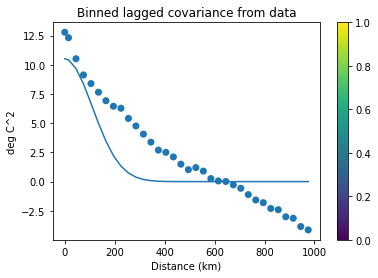

In [50]:
# fit the covariance to a Gaussian

ind = np.where(r > 600)
ind = ind[0][0]-1

c0 = cf[2] # don't fit to r = 0
cint = np.sum(cf[1:ind])*dr # integral up to where C(r) crosses the r-axis
a = c0
b = 2*cint/(a*np.sqrt(np.pi))

# functional fit
cgauss = a*np.exp(-r**2/b**2)

fig, ax = plt.subplots()
cax = ax.scatter(r, cf, s=50, edgecolors="none")
ax.set(title='Binned lagged covariance from data')
ax.set(xlabel='Distance (km)')
ax.set(ylabel='deg C^2')
cbar = fig.colorbar(cax)
gax = ax.plot(r,cgauss)

# calculate misfit between covariance and fitted functions
misfit_gauss  = np.mean((cf[1:ind]-cgauss[1:ind])**2)
esq_gauss  = np.abs(cf[0] - cgauss[0])

print('Gauss misfit   = ' + str(round(misfit_gauss,4)))
print('std error      = ' + str(round(np.sqrt(esq_gauss),4)))

Why is the covariance of the observed points negative past 600km?

## Rebuild the data-data covariance matrix

Now that we have an approximate functional fit to the covariance between any two data points, we can use this to recreate the data-data covariance matrix. Notice that the new data-data covariance matrix uses only four pieces of information, the distance between the points, the parameters $a$ and $b$, and the functional form (Gaussian). This is a dramatic reduction in complexity compared to the full covariance matrix, which was calculated directly from the data itself. 

In [51]:
# Build the data-data covariance (normalized to be 1 at r = 0)
Cdd0 = np.exp(-Rdd**2/b**2)

# Add error/signal variance to the diagonal
lam = esq_gauss/cgauss[0]
Cdd = Cdd0 + np.diag(lam*np.ones(Nm))

### Interpolate to the data points

Now let's see how good a job our fitted covariance function does. Let's use the fitted covariance function to interpolate our data back to the original data points. We can then compare these with the measured values at those locations to measure the performance of the fitted covariance function. 

The general analysis equation is
$$
D = \overline{v} + W \left( v_m - \overline{v} \right),
$$
where $D$ is the analysis estimate and $W$ is the weight matrix that for simplified optimal interpolation can be described as
$$
W = C_{im}^{model}\centerdot C_{mm}^{-1}.
$$
Here $C$ represents the covariance between the interpolated points, denoted by the subscript $i$, and the point observations, denoted by $m$.

Note that this is actual a simplified form of optimal interpolation. In this case our prior is the mean temperature. 

In [52]:
# interpolated data
D0 = np.mean(vm) + np.matmul(Cdd0,np.matmul(np.linalg.inv(Cdd),(np.array(vm)-np.mean(vm))))

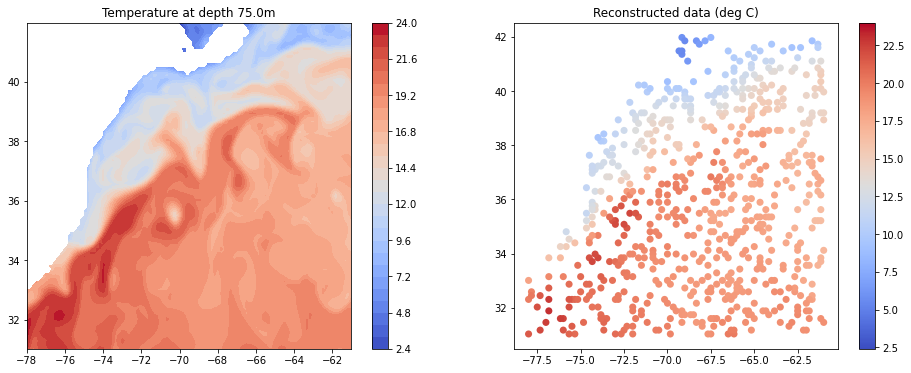

In [53]:
fig = plt.figure(figsize=(16,6))

ax  = fig.add_subplot(1,2,1)
cax = ax.contourf(lon_, lat_, temp[:,:,k],32,cmap=plt.cm.coolwarm)
ax.set(title='Temperature at depth ' + str(z[0,k]) + 'm')
cbar = fig.colorbar(cax)

ax = fig.add_subplot(1,2,2)
cax = ax.scatter(lonm, latm, c=D0, s=50, edgecolors="none",cmap=plt.cm.coolwarm,vmax=24, vmin=2.4)
ax.set(title='Reconstructed data (deg C)')
cbar = fig.colorbar(cax)

---
### Exercises

- Instead of plotting the reconstructed data, try plotting the difference between the true temperature and the reconstructed temperature. 

---

In [54]:
# Get distances separating every missing data point and every observation using
# approximate spherical geometry

lon0 = (np.max(lon)+np.min(lon))/2
lat0 = (np.max(lat)+np.min(lat))/2
rearth = 6370.8; # kilometres

# xi, yi will be the coordinates of the interpolated data (converted from lon/lat)
xi = []
yi = []

for m in range(0,Ni):
  xi.append(rearth*(np.pi/180*(loni[m]-lon0))*np.cos(np.pi/180*lati[m]))
  yi.append(rearth*(lati[m]-lat0)*np.pi/180)


xi_,xm_ = np.meshgrid(xi,xm,indexing='ij')
yi_,ym_ = np.meshgrid(yi,ym,indexing='ij')

dx = xi_ - xm_
dy = yi_ - ym_

# Note that in python * indicates elementwise multiplication, not matrix multiplication. 
Rdi = np.sqrt(dx*dx + dy*dy)

# Build the data-data covariance
Cdi = np.exp(-Rdi**2/b**2)

In [55]:
# interpolated observed data
Di = np.mean(vm) + np.matmul(Cdi,np.matmul(np.linalg.inv(Cdd),(np.array(vm)-np.mean(vm))))

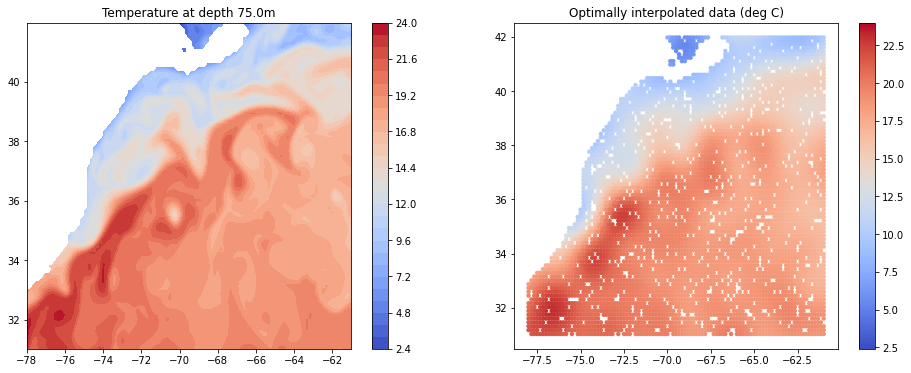

In [56]:
fig = plt.figure(figsize=(16,6))

ax  = fig.add_subplot(1,2,1)
cax = ax.contourf(lon_, lat_, temp[:,:,k],32,cmap=plt.cm.coolwarm)
ax.set(title='Temperature at depth ' + str(z[0,k]) + 'm')
cbar = fig.colorbar(cax)

ax = fig.add_subplot(1,2,2)
cax = ax.scatter(loni, lati, c=Di, s=20, edgecolors="none",cmap=plt.cm.coolwarm,vmax=24,vmin=2.4)
ax.set(title='Optimally interpolated data (deg C)')
cbar = fig.colorbar(cax)

------------------
**Exercises**

- You will notice that the optimally interpolated temperature is much smoother than the true temperature field. Why is this? How might you "sharpen" the interpolated field? 

- Your plot of the optimally interpolated data will have gaps in it because it does not include the gridpoints where you made measurements. Fill in these gaps by adding a extra line above to plot the measured values of temperature superimposed upon the optimally interpolated values: 
```
cax = ax.scatter(lonm, latm, c=vm, s=20, edgecolors="none")
```
How does this change the plot of temperature? What if you were to use the "reconstructed" data instead of the actual measured values? 

- We assumed that the data set we used was *unbiased* in the sense that the mean of the data should be close to the mean of the true temperature field. How accurate is this? What happens if you significantly reduce the number of data points? 

- The values of $a$ and $b$ were derived from the data itself. But there may be biases in these values due to undersampling, noise, etc. Try different values for $a$ and $b$ and see what this does to the covariance function and the reconstructed data. 

- Instead of the Gaussian function, we could have used a so-called Markov function: 
$$
C_M(r) = a \left( 1 + \frac{r}{b} \right) \exp \left( - r / b \right). 
$$
Modify the code above to fit the data to both a Gaussian and a Markov function and determine which produces a better fit. 

------------------

**Challenge exercises:**

- Did we need to calculate the full inverse of `Cdd` in our calculation of `D0`? Is there a more computationally efficient approach? 

- Research other techniques for fitting a function to data and apply them to our example. 

------------------
